# Análisis de la etapa de generación de medios

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import plotly.express as px

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU. Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [13]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [14]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "gasdev": ["ran2"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}
functions = ['Py_kgeneration', 'generate', 'fftma2', 'covariance', 'gasdev', 'fourt', 'cov_value', 'ran2', 'build_real', 'prebuild_gwn', 'clean_real', 'cgrid', 'length', 'maxfactor']
overall_time = {}
overall_memory = {}

In [27]:
def get_data(file_name):
    data = []
    row = {}

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            split_line = line.split()
                
            if "USED" not in split_line and "ELAPSED" not in split_line and "CPU" not in split_line: continue
    
            if "CPU" in split_line:
                idx_cpu = split_line.index("CPU") + 1
                idx_per = idx_cpu + 1
                row["cpu"] = row.get('cpu', [])
                row["cpu"].append(float(split_line[idx_per].rsplit("%")[0]))
                continue
                
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
                        
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            if "cpu" in row:
                if row["function"] == "generate": print(row["cpu"])
                row["cpu"] = sum(row["cpu"]) / len(row["cpu"])
            data.append(row)
            row = {}
            
    return data

In [23]:
def create_df(file_name):
    data = get_data(file_name)
    df = pd.DataFrame(data)
    print(df)
    return df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median'], 'cpu': ['min', 'max', 'mean']})

In [17]:
def analyze(file_name):
    df_grouped = create_df(file_name)
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [18]:
def merge_dfs(dfs):
    df_final = pd.concat(dfs, join='inner').sort_values(by=('time', 'sum'), ascending=False) 

    memory_min, memory_max, memory_median = [], [], []
    time_min, time_max, time_mean, time_sum, time_count = [], [], [], [], []
    cpu_min, cpu_max, cpu_mean = [], [], []

    for function in functions:
        memory_min.append(df_final.loc[function, ('memory', 'min')].min())
        time_min.append(df_final.loc[function, ('time', 'min')].min())
        cpu_min.append(df_final.loc[function, ('cpu', 'min')].min())
        memory_max.append(df_final.loc[function, ('memory', 'max')].max())
        time_max.append(df_final.loc[function, ('time', 'max')].max())
        cpu_max.append(df_final.loc[function, ('cpu', 'max')].max())
        time_mean.append(df_final.loc[function, ('time', 'mean')].mean())
        cpu_mean.append(df_final.loc[function, ('cpu', 'mean')].mean())
        time_sum.append(df_final.loc[function, ('time', 'sum')].sum())
        time_count.append(df_final.loc[function, ('time', 'count')].sum())
        try:
            memory_median.append(df_final.loc[function, ('memory', 'median')].median())
        except:
            memory_median.append(df_final.loc[function, ('memory', 'median')])
        
    df = pd.DataFrame({('memory', 'min'): memory_min, ('memory', 'max'): memory_max, ('memory', 'median'): memory_median, ('time', 'min'): time_min, ('time', 'max'): time_max, ('time', 'mean'): time_mean, ('time', 'sum'): time_sum, ('time', 'count'): time_count, ('cpu', 'min'): cpu_min, ('cpu', 'max'): cpu_max, ('cpu', 'mean'): cpu_mean})

    df.index = functions
    df.index.name = 'function'
    return df

In [19]:
def analyze(file_names):
    if len(file_names) == 1:
        df_grouped = create_df(file_names[0])
        return df_grouped.sort_values(by=('time', 'sum'), ascending=False)
    else:
        dfs = []
        for file_name in file_names:
            print("Executing file {}".format(file_name))
            df = create_df(file_name)
            dfs.append(df)
        return merge_dfs(dfs)

In [20]:
def plot_pie(df, function, plt, column):
    
    labels = relations[function][:]
    total = abs(df.loc[function][column])
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = abs(df.loc[func][column])
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    
    if rest > 0:
        labels.append("other")
        sizes.append(rest/total)
        explode.append(0 if rest/total > 0.01 else 0.1)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    

    if not np.isnan(sizes).all():
    
        plt.set_title(function)

        patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
        labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

        sort_legend = True
        if sort_legend:
            patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                                  key=lambda x: x[2],
                                                  reverse=True))

        plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
                   fontsize=8)

        plt.axis('equal')

def plot_pie_charts(df, title, column):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(title)
    functions = list(relations.keys())
    for i in range(2):
        for j in range(2):
            plot_pie(df,functions[2*i + j], axs[i, j], column)
    

In [21]:
parents = {
    "Py_kgeneration": "",
    "generate": "Py_kgeneration",
    "gasdev": "generate",
    "fftma2":  "Py_kgeneration",
    "covariance": "fftma2",
    "fourt": "fftma2",
    "prebuild_gwn": "fftma2",
    "ran2": "gasdev",
    "cov_value": "covariance",
}

def plot_treemap(df, column, name, title):
    df["parent"] = [parents.get(item, "") for item in df.index]
    df2 = df.reset_index()
    df2[name] = abs(df2[[column]])
    df2 = df2[["function", "parent", name]]
    fig3 = px.treemap(df2, names='function', parents='parent',values=name, color="parent", title=title)
    fig3.show()

## N = 8

### Armado del dataset

In [28]:
df = analyze(['log_8-aa'])
overall_time["8"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["8"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

[67.687209, 53.041176, 63.629412, 100.1, 62.004762, 84.983721, 68.704651, 50.688235]
            cpu        function  memory      time
0      0.012500            ran2     0.0  0.000216
1      0.000000            ran2    -0.3  0.000221
2      0.012500          gasdev    -0.3  0.001320
3      0.000000          gasdev     0.5  0.000245
4      0.000000            ran2     0.0  0.000320
5      0.000000            ran2     0.0  0.000220
6      0.000000            ran2     0.0  0.000219
7      0.000000            ran2     0.0  0.000218
8      0.025000          gasdev     0.0  0.002511
9      0.000000          gasdev     0.0  0.000222
10     0.000000            ran2     0.0  0.000213
11     0.012500            ran2    -1.0  0.000217
12     0.012500          gasdev    -2.6  0.001264
13     0.025000          gasdev    -3.0  0.000220
14     0.000000            ran2     0.0  0.000214
15     0.000000            ran2     0.0  0.000217
16     0.000000          gasdev     0.0  0.001264
17    37.537500

memory                     cpu                            time  \
                  min   max median        min        max       mean       min   
function                                                                        
Py_kgeneration   57.2  57.2   57.2  67.356665  67.356665  67.356665  1.308772   
generate         41.3  41.3   41.3  68.854896  68.854896  68.854896  0.840239   
gasdev          -14.4   3.4    0.0   0.000000  85.504167  10.033426  0.000220   
fftma2           15.9  15.9   15.9  64.717406  64.717406  64.717406  0.467197   
covariance       14.1  14.1   14.1  64.810324  64.810324  64.810324  0.457605   
ran2            -12.1   2.0    0.0   0.000000  62.562500   2.266940  0.000213   
cov_value        -5.9   1.0    0.0   0.000000  62.575000   2.182732  0.000218   
cgrid             1.3   1.3    1.3  20.883333  20.883333  20.883333  0.004164   
length            0.0   0.5    0.3   0.000000  12.525000   4.175000  0.000901   
fourt             0.0   0.0    0.0   0.000000   0.000000   0.000000  0.000347   
maxfactor         0.0   0.5    0.0   0.000000   0.000000   0.000000  0.000232   
prebuild_gwn      0.0   0.0    0.0   0.012500   0.012500   0.012500  0.000278   
clean_real        0.0   0.0    0.0   0.012500   0.012500   0.012500  0.000276   
build_real        0.5   0.5    0.5  25.025000  25.025000  25.025000  0.000273   

                                                    
                     max      mean       sum count  
function                                            
Py_kgeneration  1.308772  1.308772  1.308772     1  
generate        0.840239  0.840239  0.840239     1  
gasdev          0.011673  0.001223  0.626111   512  
fftma2          0.467197  0.467197  0.467197     1  
covariance      0.457605  0.457605  0.457605     1  
ran2            0.000454  0.000274  0.192690   702  
cov_value       0.000386  0.000264  0.184634   700  
cgrid           0.004164  0.004164  0.004164     1  
length          0.000928  0.000912  0.002737     3  
fourt           0.000380  0.000363  0.001090     3  
maxfactor       0.000289  0.000252  0.000757     3  
prebuild_gwn    0.000278  0.000278  0.000278     1  
clean_real      0.000276  0.000276  0.000276     1  
build_real      0.000273  0.000273  0.000273     1

### Comparación de tiempos

Una vez reconocidas qué funciones llaman a otras, se muestra en los siguientes gráficos cuánto tiempo consume cada función respecto del total que insume la función invocante.

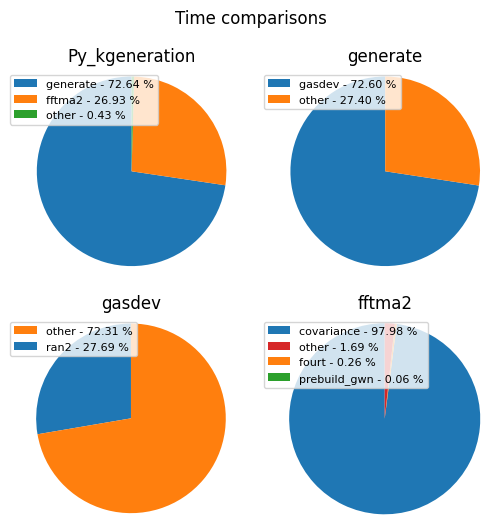

In [17]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

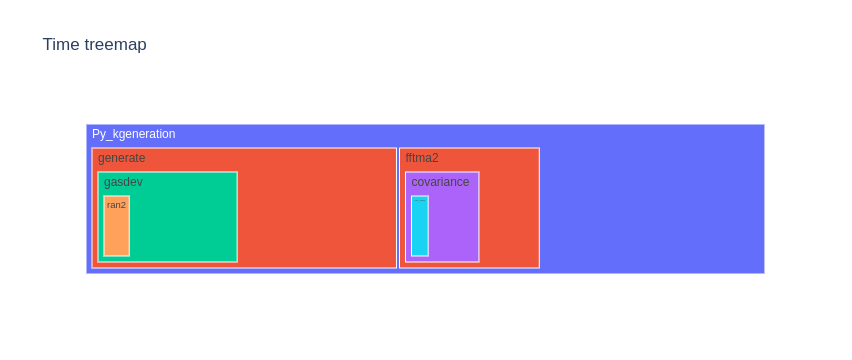

In [18]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

Una vez reconocidas qué funciones llaman a otras, se muestra en los siguientes gráficos cuánta memoria consume cada función respecto del total que insume la función invocante.

In [29]:
plot_treemap(df, ("memory", "median"), "memory_median", "Memory treemap")

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



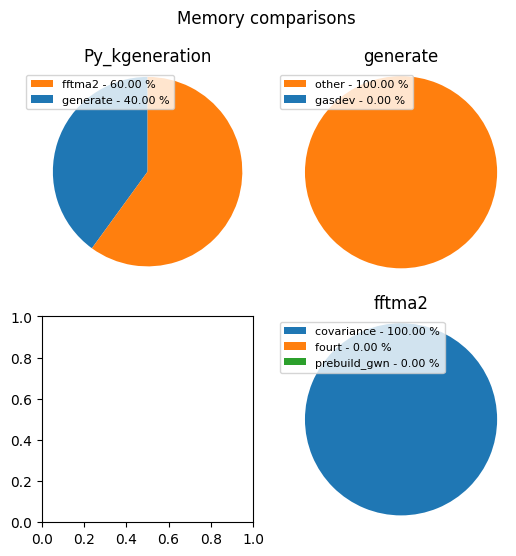

In [20]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## Mejora en generate

TODO: explicar mejor esto
    
Uso chunk array en el generate

In [30]:
df_improve = analyze(['log_8_generate_improve-aa'])
overall_time["8"] = df_improve.loc["Py_kgeneration"][("time", "sum")]
overall_memory["8"] = abs(df_improve.loc["Py_kgeneration"][("memory", "median")])
df_improve

[32.364529, 11.390323, 9.62381, 92.035484, 8.036508, 6.449206, 100.1, 19.454839]
            cpu        function  memory      time
0      0.012500            ran2     0.0  0.000215
1      0.000000            ran2    -0.8  0.000220
2      0.025000          gasdev    -0.8  0.001294
3      0.000000          gasdev     0.0  0.000218
4      6.262500            ran2     0.0  0.000226
5      0.000000            ran2     0.0  0.000216
6      0.012500            ran2     0.0  0.000215
7      0.000000            ran2     0.0  0.000214
8     16.716667          gasdev     0.0  0.002281
9      0.000000          gasdev     0.0  0.000213
10     0.000000            ran2     0.0  0.000212
11     0.000000            ran2     0.0  0.000214
12    18.775000          gasdev     0.0  0.001237
13     0.000000          gasdev     0.0  0.000214
14     0.012500            ran2     0.0  0.000211
15     0.000000            ran2     0.0  0.000215
16     0.025000          gasdev     0.0  0.001230
17     0.000000    

memory                     cpu                            time  \
                  min   max median        min        max       mean       min   
function                                                                        
Py_kgeneration   -6.2  -6.2   -6.2  34.712410  34.712410  34.712410  1.006958   
generate        -11.9 -11.9  -11.9  34.931837  34.931837  34.931837  0.623413   
gasdev          -12.9   0.5    0.0   0.000000  43.825000   4.085522  0.000191   
fftma2            5.7   5.7    5.7  34.383244  34.383244  34.383244  0.382438   
covariance        5.7   5.7    5.7  34.248686  34.248686  34.248686  0.374747   
cov_value        -0.3   1.1    0.0   0.000000  50.050000   1.313702  0.000190   
ran2             -9.9   0.5    0.0   0.000000  37.537500   0.938657  0.000189   
cgrid             0.0   0.0    0.0   0.012500   0.012500   0.012500  0.003258   
length            0.0   0.0    0.0   0.000000   0.000000   0.000000  0.000692   
fourt             0.0   0.0    0.0   0.000000   0.012500   0.004167  0.000307   
maxfactor         0.0   0.0    0.0   0.000000   0.000000   0.000000  0.000190   
prebuild_gwn      0.0   0.0    0.0  12.512500  12.512500  12.512500  0.000250   
build_real        0.0   0.0    0.0   0.000000   0.000000   0.000000  0.000236   
clean_real        0.0   0.0    0.0   0.000000   0.000000   0.000000  0.000227   

                                                    
                     max      mean       sum count  
function                                            
Py_kgeneration  1.006958  1.006958  1.006958     1  
generate        0.623413  0.623413  0.623413     1  
gasdev          0.007252  0.000918  0.469811   512  
fftma2          0.382438  0.382438  0.382438     1  
covariance      0.374747  0.374747  0.374747     1  
cov_value       0.000365  0.000221  0.154431   700  
ran2            0.000352  0.000214  0.150499   702  
cgrid           0.003258  0.003258  0.003258     1  
length          0.000702  0.000698  0.002095     3  
fourt           0.000354  0.000332  0.000997     3  
maxfactor       0.000192  0.000191  0.000573     3  
prebuild_gwn    0.000250  0.000250  0.000250     1  
build_real      0.000236  0.000236  0.000236     1  
clean_real      0.000227  0.000227  0.000227     1

In [31]:
plot_treemap(df_improve, ("memory", "median"), "memory_median", "Memory treemap")

### Análisis de la CPU

Se busca en los siguientes gráficos mostrar cómo evoluciona el uso de la CPU a lo largo de las distintas configuraciones.

El gráfico se hizo en base al promedio de uso en la CPU de todos los cores disponibles (8 en nuestras computadoras).

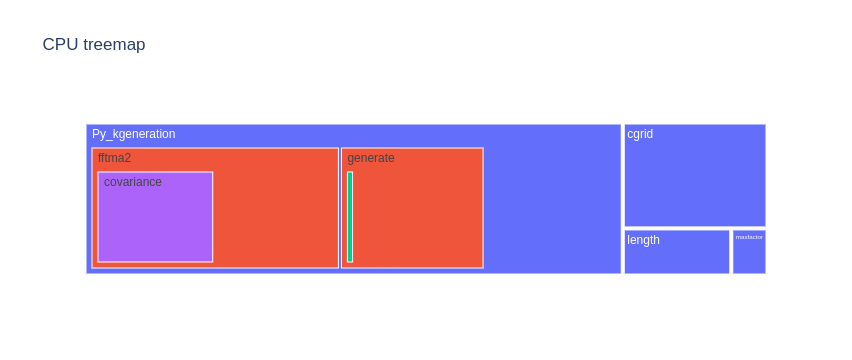

In [21]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 16

### Armado del dataset

In [11]:
df = analyze(['log_16-aa'])
overall_time["16"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["16"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

KeyError: 'function'

### Comparación de tiempos

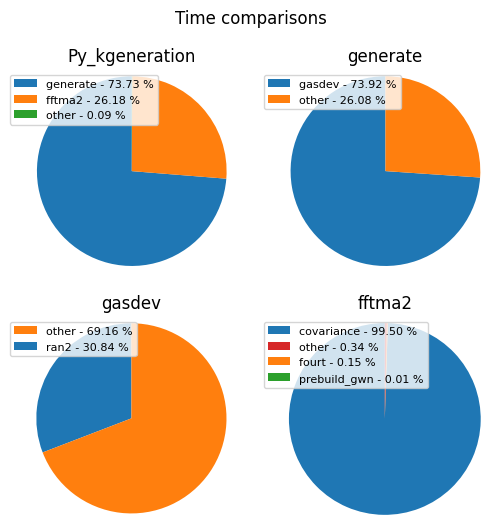

In [24]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

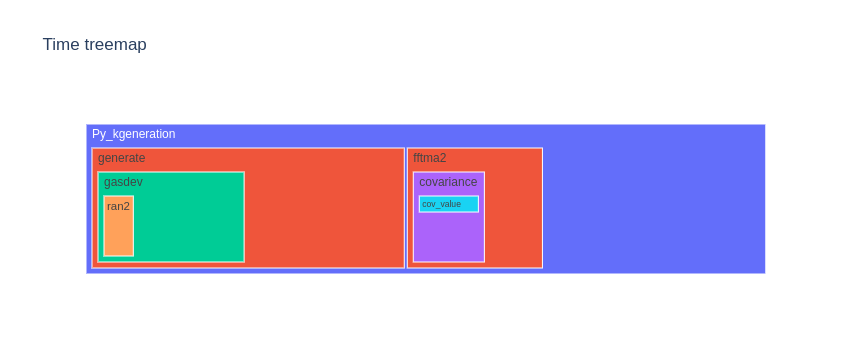

In [25]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



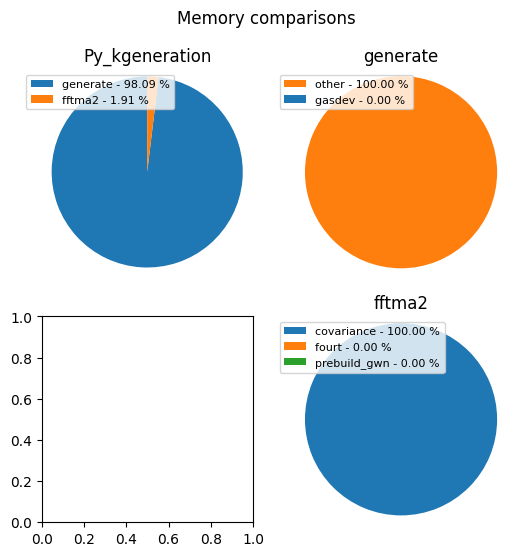

In [26]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

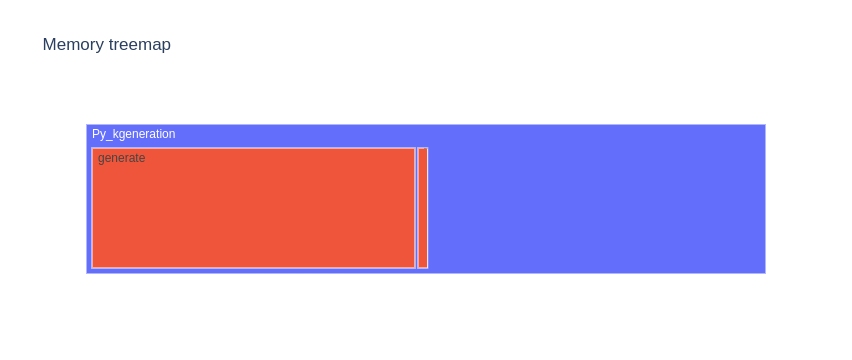

In [27]:
plot_treemap(df, ("memory", "median"), "memory_median", "Memory treemap")

### Análisis de la CPU

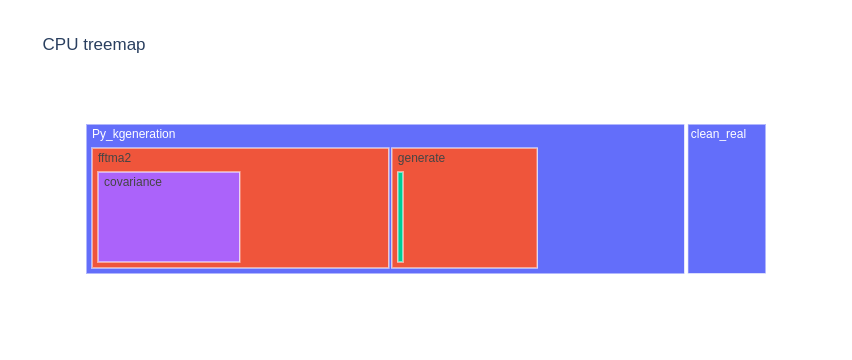

In [28]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 32

### Armado del dataset

In [29]:
df = analyze(['log_32-aa'])
overall_time["32"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["32"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

[20.294247, 10.917166, 35.779612, 14.204116, 34.126128, 10.814286, 20.231815, 28.311285]


time                                         memory  \
                      min        max       mean        sum  count    min   
function                                                                   
Py_kgeneration  22.050032  22.050032  22.050032  22.050032      1   51.1   
generate        16.448229  16.448229  16.448229  16.448229      1   31.4   
gasdev           0.000081   0.023334   0.000373  12.227146  32768   -6.0   
fftma2           5.598813   5.598813   5.598813   5.598813      1   16.5   
covariance       5.585673   5.585673   5.585673   5.585673      1   13.5   
ran2             0.000081   0.001566   0.000093   3.877959  41552   -2.2   
cov_value        0.000083   0.000243   0.000097   2.391988  24624   -2.4   
fourt            0.002374   0.003688   0.002970   0.008911      3   -0.2   
cgrid            0.001833   0.001833   0.001833   0.001833      1    0.0   
length           0.000309   0.000544   0.000456   0.001368      3    0.0   
build_real       0.000520   0.000520   0.000520   0.000520      1    1.7   
maxfactor        0.000092   0.000116   0.000098   0.000489      5    0.0   
prebuild_gwn     0.000245   0.000245   0.000245   0.000245      1    0.5   
clean_real       0.000190   0.000190   0.000190   0.000190      1    0.0   

                                   cpu                        
                 max median        min        max       mean  
function                                                      
Py_kgeneration  51.1   51.1  20.691014  20.691014  20.691014  
generate        31.4   31.4  21.834832  21.834832  21.834832  
gasdev           3.7    0.0   0.000000  71.950000   1.199399  
fftma2          16.5   16.5  17.350988  17.350988  17.350988  
covariance      13.5   13.5  17.329150  17.329150  17.329150  
ran2             1.5    0.0   0.000000  50.050000   0.287221  
cov_value        1.0    0.0   0.000000  50.050000   0.237855  
fourt            3.7    0.5   0.025000  18.825000  12.541667  
cgrid            0.0    0.0   0.012500   0.012500   0.012500  
length           0.0    0.0   0.000000   0.012500   0.004167  
build_real       1.7    1.7   0.000000   0.000000   0.000000  
maxfactor        0.0    0.0   0.000000   0.000000   0.000000  
prebuild_gwn     0.5    0.5   0.000000   0.000000   0.000000  
clean_real       0.0    0.0   0.000000   0.000000   0.000000

### Comparación de tiempos

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning:

normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 



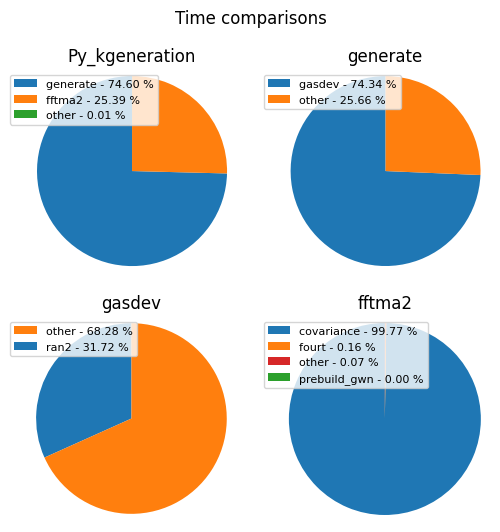

In [30]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

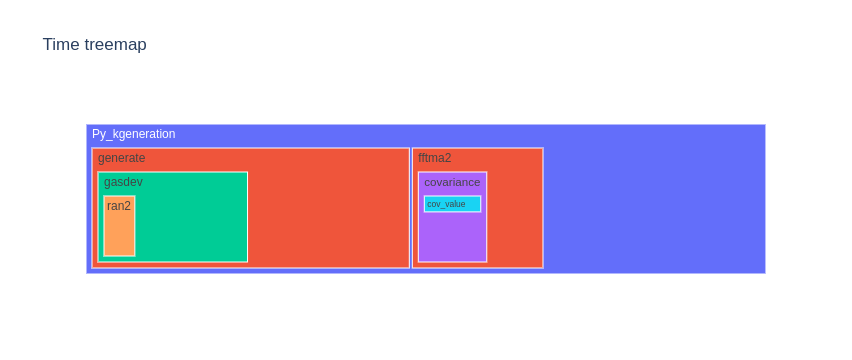

In [31]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



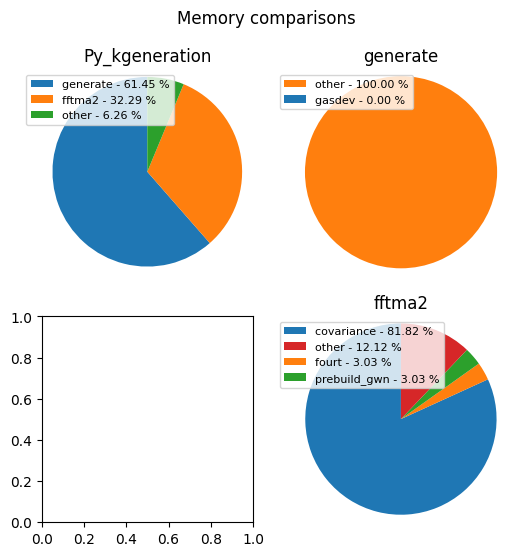

In [32]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

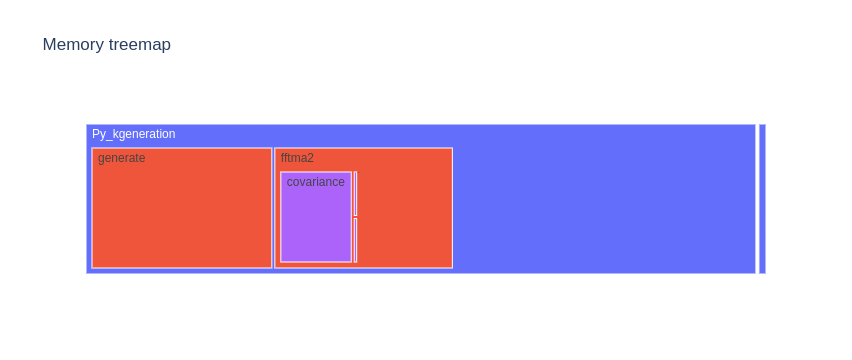

In [33]:
plot_treemap(df, ("memory", "median"), "memory_median", "Memory treemap")

### Análisis de la CPU

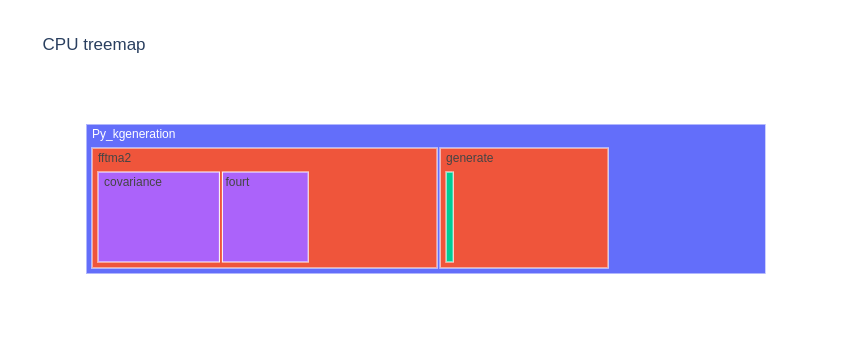

In [34]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 64

### Armado del dataset

In [35]:
df = analyze(['log_64-aa', 'log_64-ab'])
overall_time["64"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["64"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file log_64-aa
Executing file log_64-ab
[21.502423, 38.151106, 16.773406, 21.064163, 29.865098, 14.264737, 12.91298, 23.850997]


memory                      time                          \
                  min    max median         min         max        mean   
function                                                                  
Py_kgeneration  101.9  101.9  101.9  187.522037  187.522037  187.522037   
generate        130.7  130.7  130.7  147.209599  147.209599  147.209599   
fftma2          -23.5  -23.5  -23.5   40.309987   40.309987   40.309987   
covariance      -27.7  -27.7  -27.7   40.197321   40.197321   40.197321   
gasdev          -17.5    4.0    0.0    0.000082    0.024481    0.000432   
fourt            -2.8    1.7    0.0    0.026273    0.050759    0.034596   
cov_value        -7.9    2.4    0.0    0.000097    0.000322    0.000110   
ran2             -9.9    2.2    0.0    0.000080    0.002500    0.000108   
build_real        0.0    0.0    0.0    0.003251    0.003251    0.003251   
prebuild_gwn      2.5    2.5    2.5    0.001102    0.001102    0.001102   
clean_real        0.9    0.9    0.9    0.000842    0.000842    0.000842   
cgrid             0.0    0.0    0.0    0.001988    0.001988    0.001988   
length            0.0    0.0    0.0    0.000358    0.000641    0.000455   
maxfactor         0.0    0.0    0.0    0.000105    0.000110    0.000107   

                                            cpu                        
                       sum     count        min        max       mean  
function                                                               
Py_kgeneration  187.522037       1.0  22.304077  22.304077  22.304077  
generate        147.209599       1.0  22.298114  22.298114  22.298114  
fftma2           40.309987       1.0  22.327810  22.327810  22.327810  
covariance       40.197321       1.0  22.350181  22.350181  22.350181  
gasdev          109.614138  262144.0   0.000000  75.075000   1.426999  
fourt             0.103787       3.0   1.885714  19.458974   9.624075  
cov_value        17.194905  156816.0   0.000000  62.562500   0.351814  
ran2             34.852101  333450.0   0.000000  62.562500   0.350892  
build_real        0.003251       1.0   0.037500   0.037500   0.037500  
prebuild_gwn      0.001102       1.0   0.025000   0.025000   0.025000  
clean_real        0.000842       1.0   8.345833   8.345833   8.345833  
cgrid             0.001988       1.0   0.012500   0.012500   0.012500  
length            0.001365       3.0   0.000000   0.000000   0.000000  
maxfactor         0.000427       4.0   0.000000   0.000000   0.000000

### Comparación de tiempos

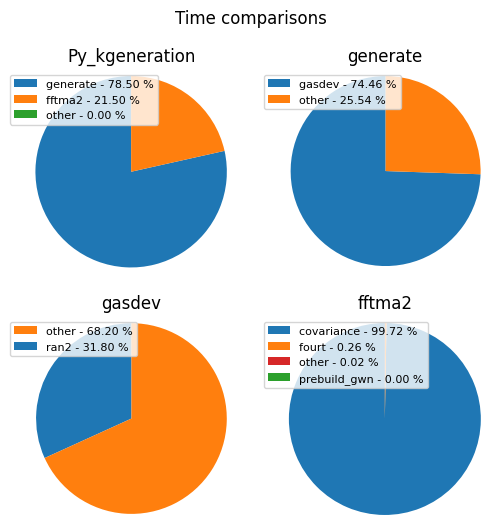

In [36]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

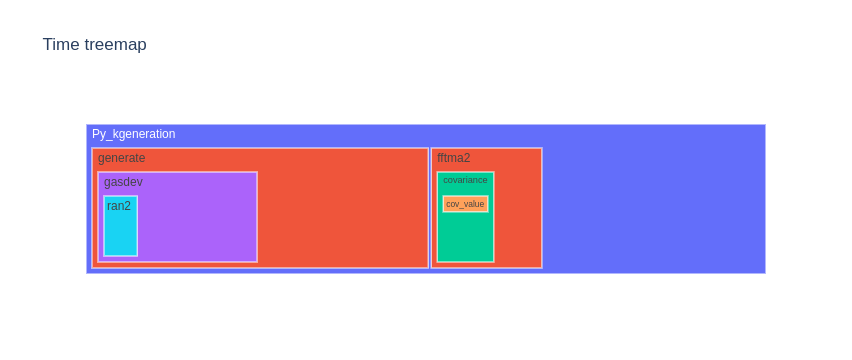

In [37]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



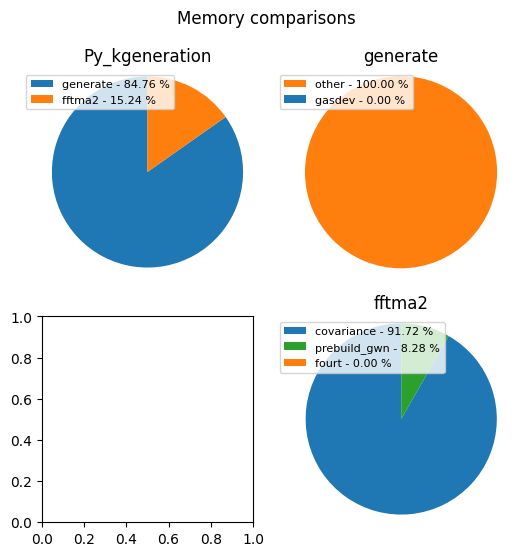

In [38]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

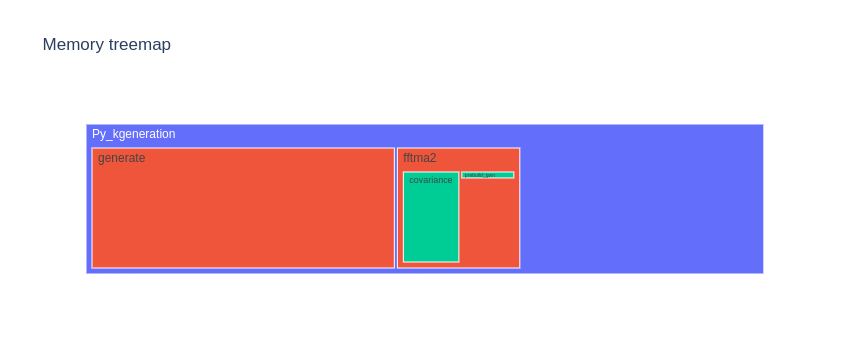

In [39]:
plot_treemap(df, ("memory", "median"), "memory_median", "Memory treemap")

### Análisis de la CPU

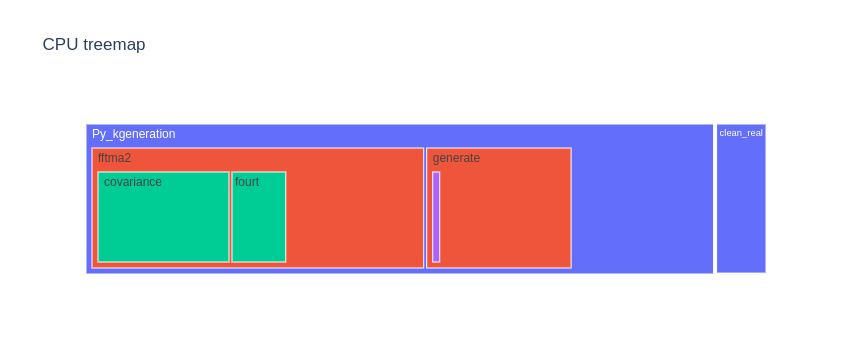

In [40]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 128

### Armado del dataset

In [41]:
df = analyze(['log_128-aa', 'log_128-ab', 'log_128-ac', 'log_128-ad', 'log_128-ae', 'log_128-af', 'log_128-ag', 'log_128-ah', 'log_128-ai', 'log_128-aj', 'log_128-ak'])
overall_time["128"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["128"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file log_128-aa
Executing file log_128-ab
Executing file log_128-ac
Executing file log_128-ad
Executing file log_128-ae
Executing file log_128-af
Executing file log_128-ag
Executing file log_128-ah
Executing file log_128-ai
[21.809131, 29.575357, 17.376702, 22.28339, 34.225339, 17.65522, 13.884919, 22.901137]
Executing file log_128-aj
Executing file log_128-ak


memory                       time                            \
                  min    max median          min          max         mean   
function                                                                     
Py_kgeneration  502.7  502.7  502.7  1501.888817  1501.888817  1501.888817   
generate        487.7  487.7  487.7  1208.273905  1208.273905  1208.273905   
fftma2           33.3   33.3   33.3   293.611836   293.611836   293.611836   
covariance       51.2   51.2   51.2   292.433842   292.433842   292.433842   
gasdev          -37.7    7.9    0.0     0.000082     0.024570     0.000430   
fourt           -15.8    0.2   -1.5     0.314016     0.472070     0.379703   
cov_value       -11.4    3.4    0.0     0.000095     0.000542     0.000110   
ran2            -27.9    3.0    0.0     0.000081     0.001710     0.000107   
build_real        0.0    0.0    0.0     0.019131     0.019131     0.019131   
prebuild_gwn     -1.9   -1.9   -1.9     0.009350     0.009350     0.009350   
clean_real       14.7   14.7   14.7     0.005629     0.005629     0.005629   
cgrid             0.0    0.0    0.0     0.001644     0.001644     0.001644   
length            0.0    0.0    0.0     0.000345     0.000378     0.000357   
maxfactor         0.0    0.0    0.0     0.000102     0.000104     0.000103   

                                              cpu                         
                        sum      count        min         max       mean  
function                                                                  
Py_kgeneration  1501.888817        1.0  22.449193   22.449193  22.449193  
generate        1208.273905        1.0  22.463899   22.463899  22.463899  
fftma2           293.611836        1.0  22.389739   22.389739  22.389739  
covariance       292.433842        1.0  22.374167   22.374167  22.374167  
gasdev           900.104776  2097152.0   0.000000  100.100000   1.409411  
fourt              1.139109        3.0  24.372092   32.752676  27.178624  
cov_value        125.023851  1132300.0   0.000000   75.075000   0.362679  
ran2             286.139310  2668394.0   0.000000   87.587500   0.354400  
build_real         0.019131        1.0  19.110417   19.110417  19.110417  
prebuild_gwn       0.009350        1.0  38.294445   38.294445  38.294445  
clean_real         0.005629        1.0  15.062500   15.062500  15.062500  
cgrid              0.001644        1.0   6.275000    6.275000   6.275000  
length             0.001072        3.0   0.000000    0.025000   0.008333  
maxfactor          0.000309        3.0   0.000000    0.000000   0.000000

### Comparación de tiempo

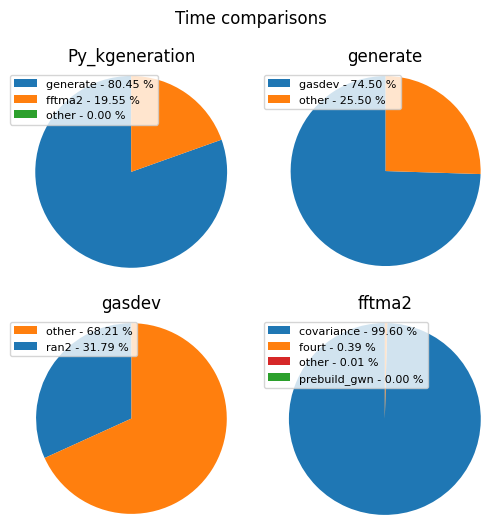

In [42]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

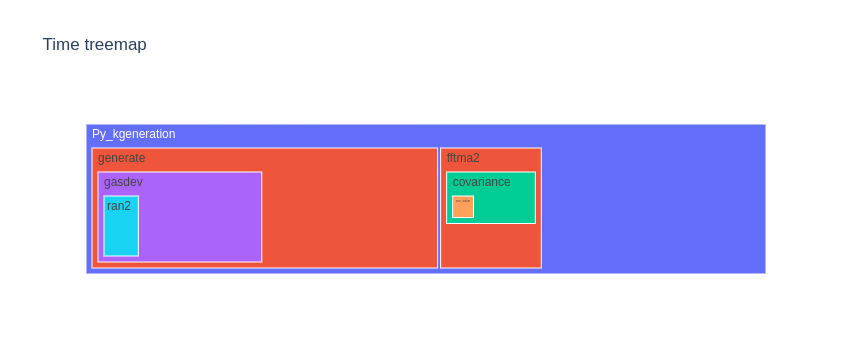

In [43]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



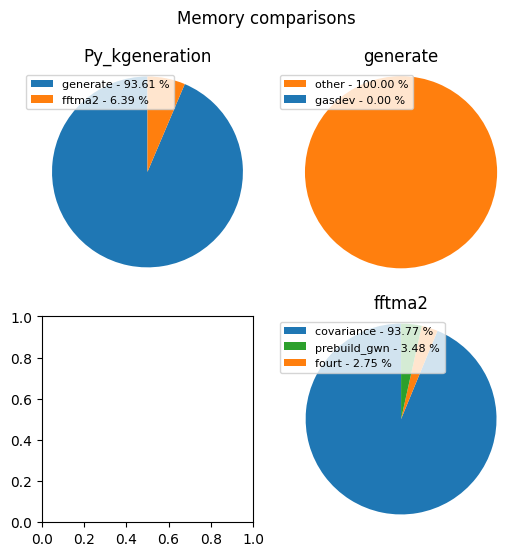

In [44]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

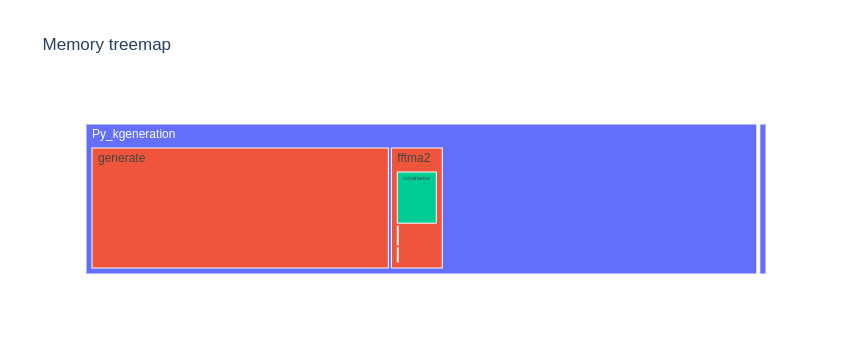

In [45]:
plot_treemap(df, ("memory", "median"), "memory_median", "Memory treemap")

### Análisis de la CPU

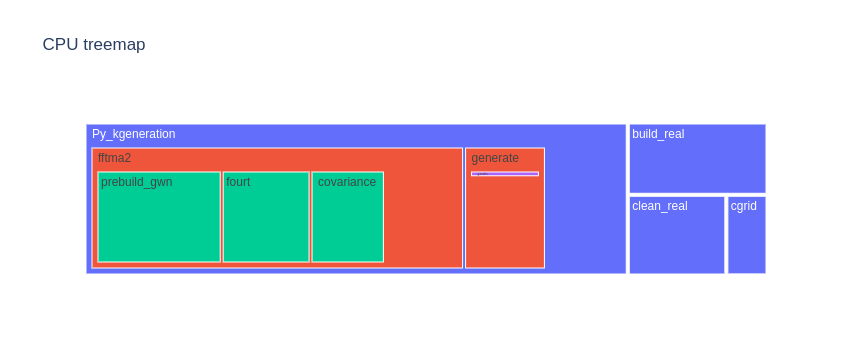

In [46]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 256

### Armado del dataset

In [94]:
df = analyze(['log_256-aa', 'log_256-ab', 'log_256-ac'])
overall_time["256"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["256"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file number 1 out of 10
Executing file number 2 out of 10
Executing file number 3 out of 10
Executing file number 4 out of 10
Executing file number 5 out of 10
Executing file number 6 out of 10
Executing file number 7 out of 10
Executing file number 8 out of 10
Executing file number 9 out of 10
Executing file number 10 out of 10


In [96]:
merge_dfs(dfs)

memory                        time                            \
                   max  median     min       count          max         mean   
function                                                                       
Py_kgeneration  7421.6  7421.6  7421.6         1.0  1226.822575  1226.822575   
generate        6691.7  6691.7  6691.7         1.0   959.799368   959.799368   
fftma2           872.0   872.0   872.0         1.0   267.021516   267.021516   
covariance       870.5   870.5   870.5         1.0   247.512194   247.512194   
gasdev             8.7     0.0   -13.5  16777216.0     0.001358     0.000033   
fourt             11.5    -1.4   -16.2         3.0     8.429829     6.378454   
cov_value          0.7     0.0   -13.9   8855600.0     0.000437     0.000002   
ran2               0.9     0.0    -0.8  21359556.0     0.000381     0.000002   
build_real        -0.2    -0.2    -0.2         1.0     0.151968     0.151968   
prebuild_gwn       6.5     6.5     6.5         1.0     0.108160     0.108160   
clean_real       127.2   127.2   127.2         1.0     0.095267     0.095267   
cgrid              0.0     0.0     0.0         1.0     0.000160     0.000160   
length             0.0     0.0     0.0         3.0     0.000043     0.000034   
maxfactor          0.0     0.0     0.0         5.0     0.000002     0.000002   

                                          
                        min          sum  
function                                  
Py_kgeneration  1226.822575  1226.822575  
generate         959.799368   959.799368  
fftma2           267.021516   267.021516  
covariance       247.512194   247.512194  
gasdev             0.000000   564.182445  
fourt              5.015006    19.135362  
cov_value          0.000001    21.579349  
ran2               0.000000    45.002553  
build_real         0.151968     0.151968  
prebuild_gwn       0.108160     0.108160  
clean_real         0.095267     0.095267  
cgrid              0.000160     0.000160  
length             0.000021     0.000102  
maxfactor          0.000001     0.000008

### Comparación de tiempos

In [ ]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [ ]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

In [ ]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

In [ ]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## Tiempo insumido con distintos N

Se busca mostrar en los siguientes gráficos la relación exponencial que existe entre el tiempo insumido por cada una de las configuraciones de distinto N.

In [94]:
def plot_overall_comparison(info, title, unit):
    fig = plt.figure()
    plt.title(title)
    plt.bar(info.keys(),info.values())
    plt.ylabel(unit)
    plt.xlabel("sizes")
    plt.show()

{'8': 0.544398, '16': 2.908668, '32': 22.135483, '64': 178.629961}


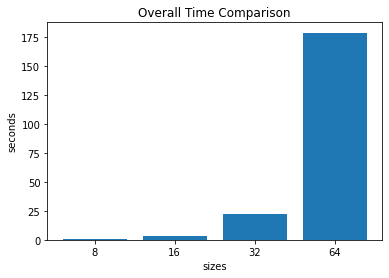

In [95]:
print(overall_time)
plot_overall_comparison(overall_time, "Overall Time Comparison", "seconds")

{'8': 0.2, '16': 11.1, '32': 53.6, '64': 304.2}


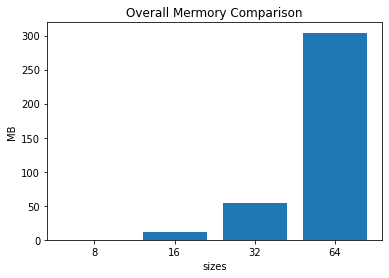

In [97]:
print(overall_memory)
plot_overall_comparison(overall_memory, "Overall Mermory Comparison", "MB")

## Identificación de valores usados en las funciones más invocadas

Con los gráficos de las secciones anteriores es posible identificar qué funciones son las que son llamadas una mayor cantidad de veces: `gasdev`, `cov_value` y `ran2`. 

El objetivo de esta sección es analizar con qué valores se llaman a estas funciones para identificar patrones y diferencias.

In [20]:
functions_repeated = {
    "gasdev":["idum", "idum2", "iy"],
    "cov_value": ["di", "dj", "dk"],
    "ran2": ["idum", "idum2", "iy"],
}

def get_data_from_file(file_name):
    data = {
        "gasdev": {"idum": [], "idum2": [], "iy": []},
        "ran2": {"idum": [], "idum2": [], "iy": []},
        "cov_value": {"di":[], "dj": [], "dk": []}
    }
    
    return_values = {
        "gasdev": [],
        "ran2": [],
        "cov_value": []
    }

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            if np.any([f in line for f in functions_repeated.keys()]) and "RESULT = in progress" in line:
                split_line = line.split()
                function_name = get_function_name(split_line[2])
                params = functions_repeated[function_name]
                for p in params:
                    idx_value = split_line.index(p) + 2
                    data[function_name][p].append(float(split_line[idx_value].rsplit(",")[0]))
                    
            elif np.any([f in line for f in functions_repeated.keys()]) and "RESULT = success" in line:
                split_line = line.split()
                function_name = get_function_name(split_line[2])
                return_values[function_name].append(float(split_line[8].rsplit(",")[0]))
    return data, return_values

def get_repeteated_data(filenames):
    data_total = {}
    return_total = {}
    for f in filenames:
        data, return_values = get_data_from_file(f)
        data_total = {**data_total, **data}
        return_total = {**return_total, **return_values}
    return data_total, return_total

In [12]:
def distribution(data,f, p, plt):
    values = data[f][p]
    if np.isnan(values).all(): return # TODO: Pasa algo raro con gasdev iy en 32
    plt.set_title(f"{p}")
    plt.hist(values, bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
    plt.grid(True)
    plt.set_ylabel("Number of repetitions")
    plt.set_xlabel("value")

def plot_distributions(data, f):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(f"Distribution in params for {f}")
    params = list(data[f].keys())
    for i in range(2):
        for j in range(2):
            if 2*i + j < len(params):
                distribution(data, f,params[2*i + j], axs[i, j])
                
    
    fig.delaxes(axs[1, 1])
    fig.tight_layout(pad=3.0)

In [21]:
def plot_reapeated_data_distribution(data):
    for f in functions_repeated.keys():
        plot_distributions(data,f)

In [23]:
def plot_return_values_dist(return_values):
    for f in return_values.keys():
        
        fig = plt.figure()
        plt.title(f"Distribution of {f} return value")
        plt.hist(return_values[f], bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
        plt.grid(True)
        plt.ylabel("Number of repetitions")
        plt.xlabel("value")
        plt.show()

## N = 8

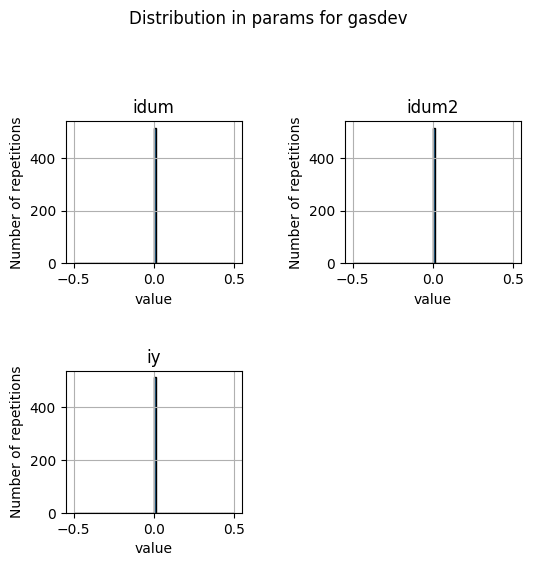

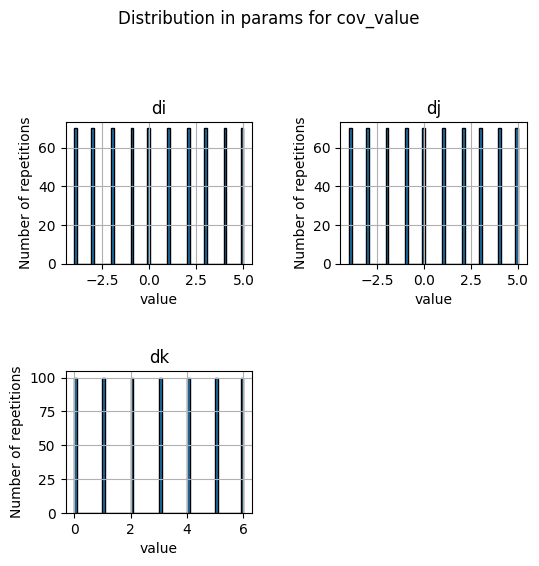

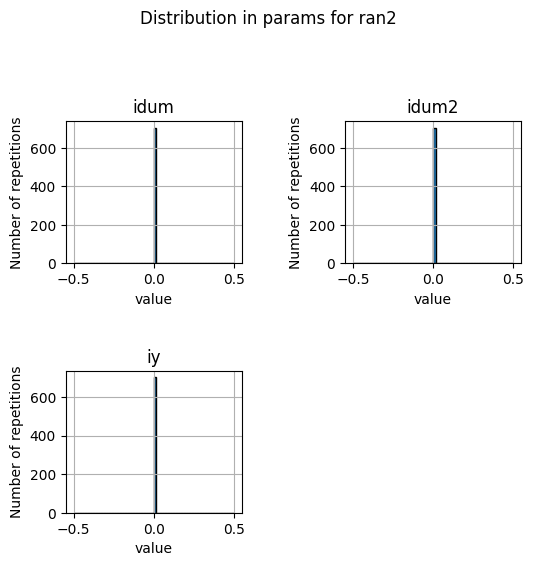

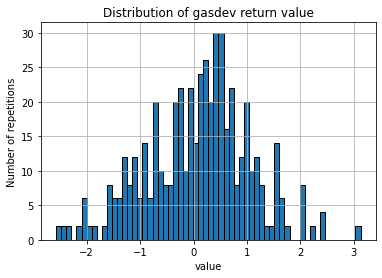

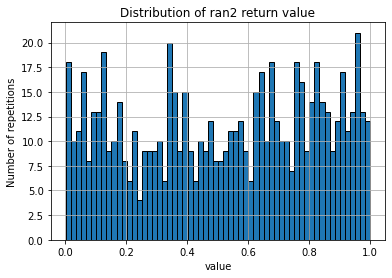

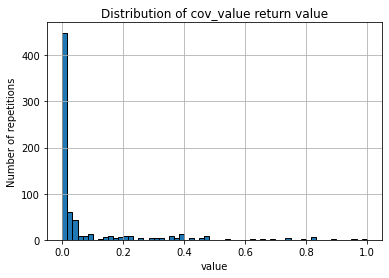

In [26]:
data, return_values = get_repeteated_data(['log_8-aa'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## N = 16

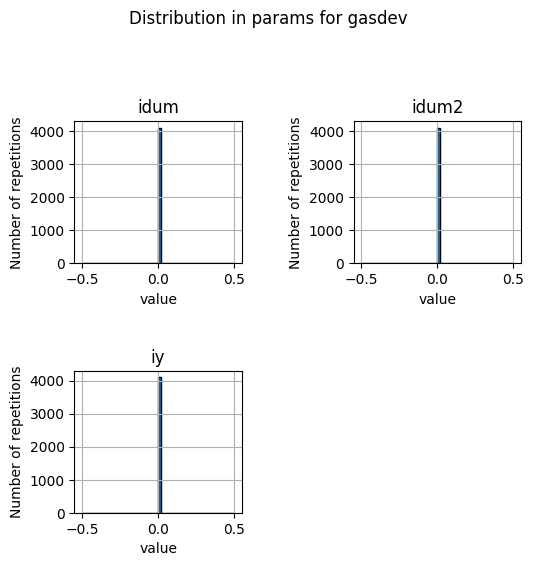

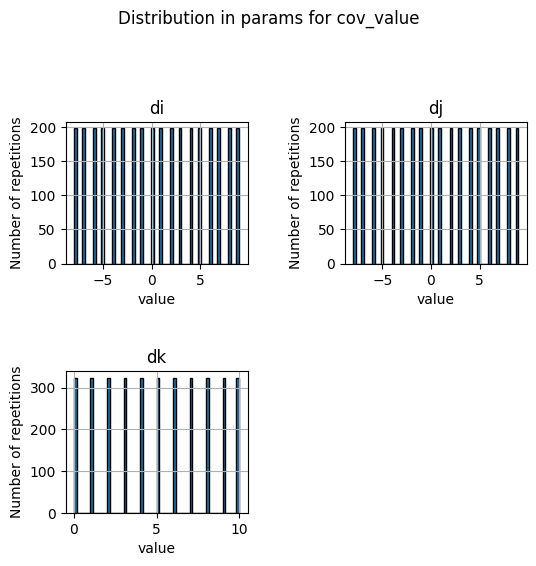

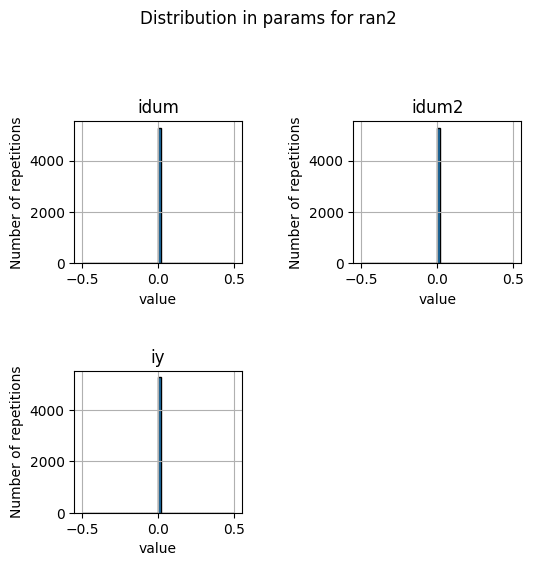

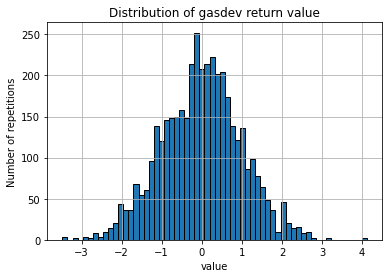

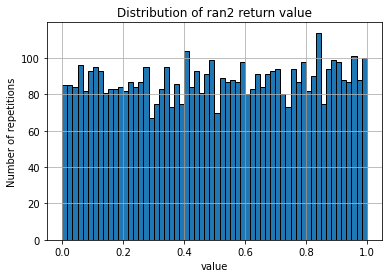

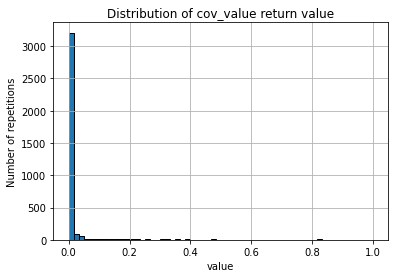

In [27]:
data, return_values = get_repeteated_data(['log_16-aa'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## N = 32

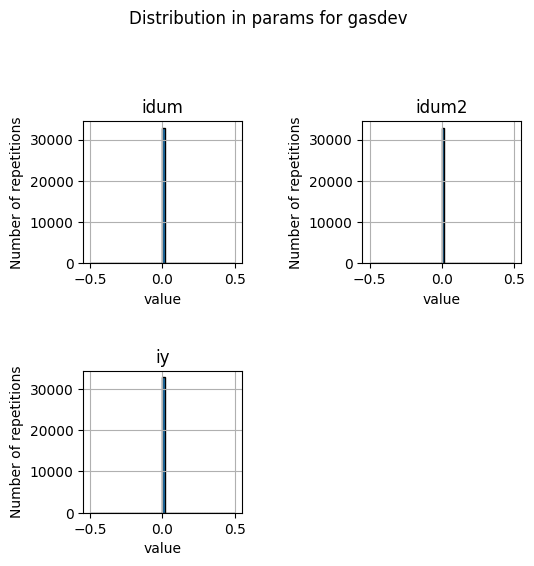

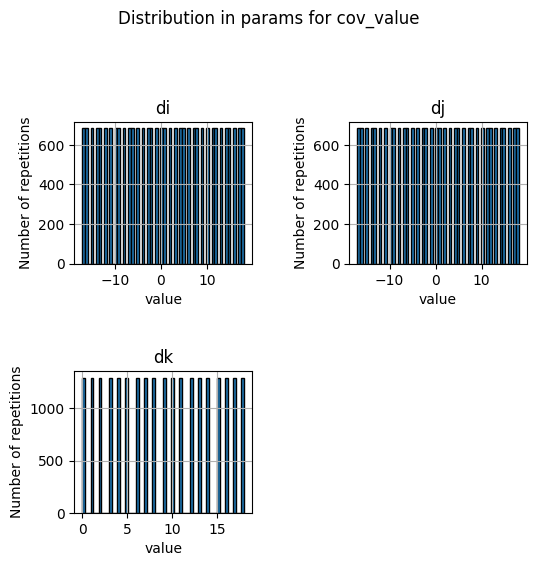

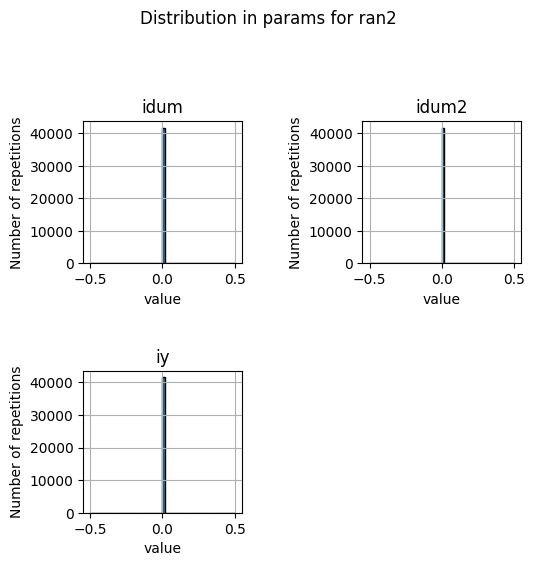

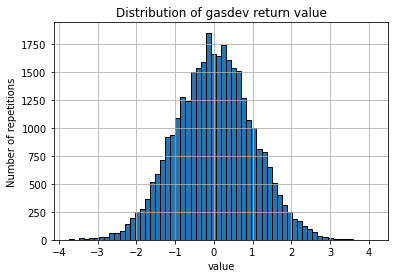

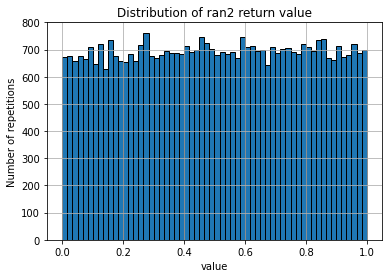

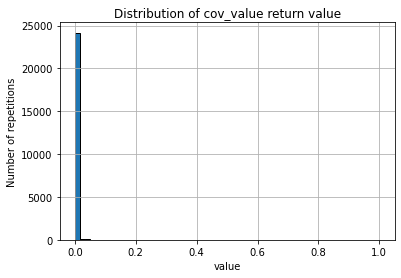

In [25]:
data, return_values = get_repeteated_data(['log_32-aa'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## N = 64

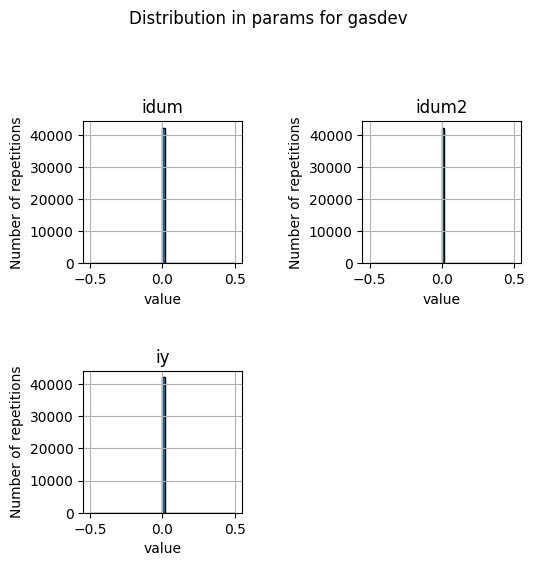

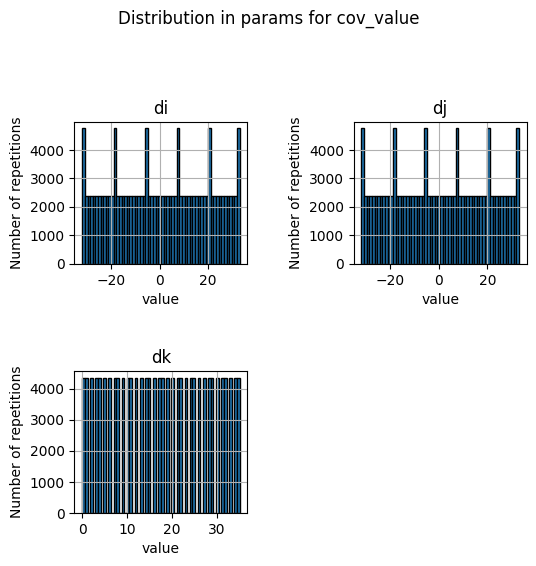

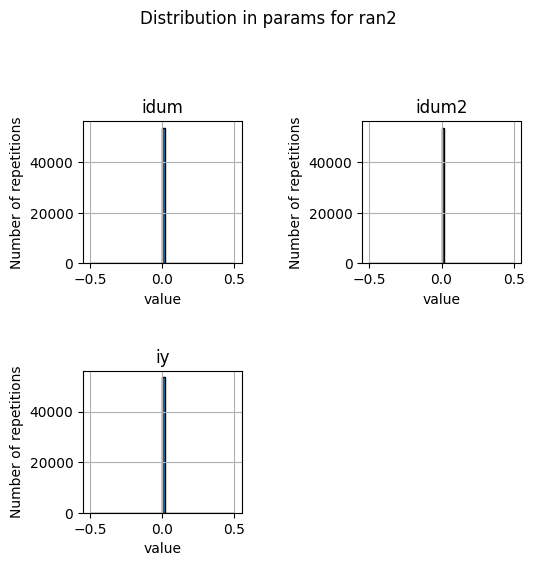

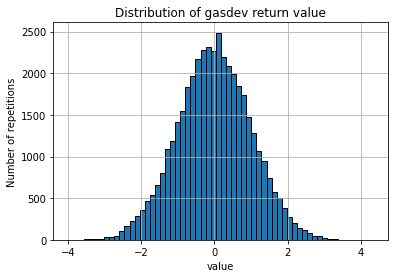

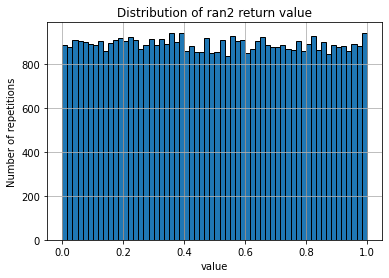

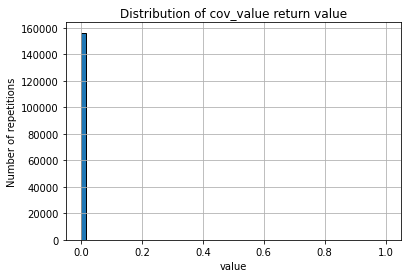

In [28]:
data, return_values = get_repeteated_data(['log_64-aa', 'log_64-ab'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## Conclusiones de los parametros

**Parametros de gasdev**

- idum: siempre 0
- idum2: siempre 0
- iy: siempre 0

**Parametros de ran2**

- idum: siempre 0
- idum2: siempre 0
- iy: siempre 0

**Parametros de cov_value**

- di:
- dj:
- dk:

## Conclusiones de los valores de retorno

Parece ser que las 3 funciones tienen distribuciones bien marcadas:
- gasdev: es una normal(0, 500)
- ran2: uniforme(0,1)
- cov_value: parece solo devolver 0, sobre todo amedida que se agranda el tamaño del medio

# TODO

- [ ] Completar analisis de memoria y cpu
- [ ] Investigar mas el tema de llamadas a funciones repetidas (gasdev, cov_value, ran2)
- [ ] Escribir conclusiones (proximos pasos y cosas que no se consideran importantes)
- [X] Conseguir ayuda en tupac para poder correrlo

## Corriendo en TUPAC

Corriendo la simulacion de un medio en tupac encontramos que la mayor limitacion de correr un medio de 1024 es la memoria que se llena a los 4 minutos y no permite seguir corriendo la simulacion.

Por lo tanto consideramos que lo primero a optimizar es el uso de memoria para poder completar la generacion con un tamaño de 1024.

### Optimizacion en memoria

Viendo cual es la funcion que mas memoria consume: `generate` hay que reducir el uso de memoria en dicha funcion.